# Creating timelapse animations

This example illustrates how to use an `EOWorkflow` to create a time-lapse. The process is done by first defining some area and the time interval of interest. Then the following workflow will be performed:

Tasks of the workflow:

 * download S2 images (RGB + CLM)
 * filter out images with cloud coverage larger than a given threshold (e.g. 0.05)
 
When the eopatches have been filtered, we create an animation with the help of external packages.

In [1]:
import os
from datetime import timedelta

import imageio
import numpy as np
from IPython.display import Image

from sentinelhub import CRS, BBox, DataCollection

from eolearn.core import EOWorkflow, FeatureType, OutputTask, linearly_connect_tasks
from eolearn.features import SimpleFilterTask
from eolearn.io import SentinelHubInputTask

## 1. Define tasks

First we need to define the download and filter tasks which we need for obtaining the data and filtering it.

### 1.1 Download Task

The download task accepts a few parameters that you have to set, some of which area shown below. For more information regarding the parameters, check the task [documentation](https://eo-learn.readthedocs.io/en/latest/eolearn.io.processing_api.html#eolearn.io.processing_api.SentinelHubInputTask) page.

In addition to the RGB bands, we also add the cloud mask `CLM` band, which provides information regarding the clouds. More info [here](https://docs.sentinel-hub.com/api/latest/#/API/data_access?id=cloud-masks-and-cloud-probabilities).

In [2]:
add_data_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands_feature=(FeatureType.DATA, "RGB"),
    bands=["B04", "B03", "B02"],
    time_difference=timedelta(hours=2),
    resolution=10,
    additional_data=[(FeatureType.MASK, "CLM")],
)

### 1.2 Filter Task

The `SimpleFilterTask` has to be provided with some logic in order to filter the framers accordingly. This is why the `MaxCCPredicate` function is created. It accepts the cloud image and checks the cloud coverage. If the value of cloud coverage is too high (w.r.t. the provided threshold), the frame is filtered out.

In [3]:
class MaxCCPredicate:
    def __init__(self, maxcc):
        self.maxcc = maxcc

    def __call__(self, img_cm):
        w, h, _ = img_cm.shape
        cc = np.sum(img_cm) / (w * h)
        return cc <= self.maxcc


filter_task = SimpleFilterTask((FeatureType.MASK, "CLM"), MaxCCPredicate(maxcc=0.05))

## 2. Create and execute workflow

We will download the Sentinel-2 images for the period of the Istanbul airport construction.

In [4]:
# define region and time interval of interest
roi_bbox = BBox(bbox=[28.726330, 41.248773, 28.759632, 41.274581], crs=CRS.WGS84)
time_interval = ("2017-06-01", "2019-01-01")

In [5]:
# define workflow
nodes = linearly_connect_tasks(add_data_task, filter_task, OutputTask("eopatch"))
workflow = EOWorkflow(nodes)

# execute workflow
result = workflow.execute({nodes[0]: {"bbox": roi_bbox, "time_interval": time_interval}})

# extract eopatch
eopatch = result.outputs["eopatch"]

## 3. Create animation

In [6]:
def make_gif(eopatch, output_path, fps):
    """
    Generates a GIF animation from an EOPatch.
    """
    with imageio.get_writer(output_path, mode="I", fps=fps) as writer:
        for image in eopatch:
            writer.append_data(np.array(image, dtype=np.uint8))

In [7]:
OUTPUT_GIF_PATH = os.path.join(".", "outputs", "eopatch.gif")
DURATION = 4  # seconds

make_gif(
    eopatch=np.clip(eopatch.data["RGB"] * 2.5 * 255, 0, 255),
    output_path=OUTPUT_GIF_PATH,
    fps=len(eopatch.timestamps) / DURATION,
)

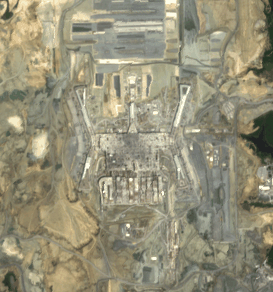

In [8]:
Image(filename=OUTPUT_GIF_PATH, width=500)